# Assignment — Node Embeddings

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD, PCA
import requests
from sklearn.model_selection import train_test_split
import networkx as nx
from sklearn.metrics import f1_score
from tqdm.notebook import tqdm
from time import time
from sklearn.ensemble import GradientBoostingClassifier

### Cora dataset EDA

The Cora dataset consists of 2708 scientific publications classified into one of seven classes. The citation network consists of 5429 links. Let us take a closer look at this dataset.

In [2]:
url = 'https://raw.githubusercontent.com/netspractice/network-science/main/datasets/cora_cites.txt'
open('cora_cites.txt', 'wb').write(requests.get(url).content)

url = 'https://raw.githubusercontent.com/netspractice/network-science/main/datasets/cora_content.txt'
open('cora_content.txt', 'wb').write(requests.get(url).content);

Number of nodes in the graph

In [3]:
cora = nx.read_edgelist('cora_cites.txt')
len(cora)

2708

Number of nodes in a gigantic connected component (GCC)

In [4]:
gcc_nodes = sorted(list(nx.connected_components(cora)), 
                   key=lambda x: len(x))[-1]
gcc_cora = cora.subgraph(gcc_nodes).copy()
len(gcc_cora)

2485

Nodes content

In [5]:
cora_content = pd.read_csv('cora_content.txt', sep='	', 
                           header=None, index_col=0)
cora_content.index = cora_content.index.astype('str')
cora_content.index.name = 'node'
cora_content.iloc[:5, :20]

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
node,,,,,,,,,,,,,,,,,,,,
31336,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1061127,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1106406,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
13195,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
37879,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary. The dictionary consists of 1433 unique words. In this assignment, we will only work with categories and will not touch any information about words.

Examples of node categories

In [6]:
category = cora_content.loc[gcc_nodes, [1434]]
category = category.rename(columns={1434: 'category_name'})
category.head()

,category_name
node,
116087,Rule_Learning
753264,Theory
650807,Genetic_Algorithms
1102646,Neural_Networks
590022,Probabilistic_Methods


In [7]:
cora_content

,1,2,3,4,5,6,7,8,9,10,...,1425,1426,1427,1428,1429,1430,1431,1432,1433,1434
node,,,,,,,,,,,,,,,,,,,,,
31336,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,Neural_Networks
1061127,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,Rule_Learning
1106406,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
13195,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
37879,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Probabilistic_Methods
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128975,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Genetic_Algorithms
1128977,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Genetic_Algorithms
1128978,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Genetic_Algorithms


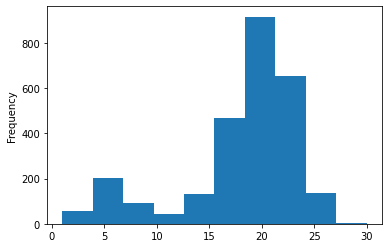

In [8]:
cora_content.iloc[:, :-1].sum(axis=1).plot.hist()

Category distribution

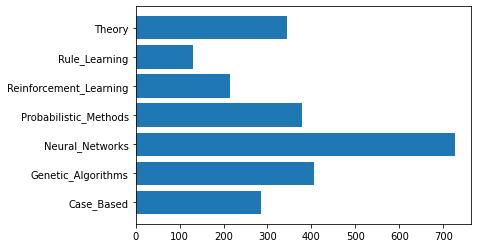

In [9]:
plt.barh(*np.unique(category, return_counts=True));

Rename categories to integer numbers (ids)

In [10]:
category['category_id'] = np.unique(category.category_name, 
                                    return_inverse = True)[1]
category.head()

,category_name,category_id
node,,
116087,Rule_Learning,5
753264,Theory,6
650807,Genetic_Algorithms,1
1102646,Neural_Networks,2
590022,Probabilistic_Methods,3


In [11]:
category

,category_name,category_id
node,,
116087,Rule_Learning,5
753264,Theory,6
650807,Genetic_Algorithms,1
1102646,Neural_Networks,2
590022,Probabilistic_Methods,3
...,...,...
294030,Probabilistic_Methods,3
156977,Neural_Networks,2
157761,Theory,6


Assortativity coefficient

In [12]:
nx.set_node_attributes(gcc_cora, category.category_id.to_dict(), 'category')
gcc_cora = nx.convert_node_labels_to_integers(gcc_cora)
round(nx.attribute_assortativity_coefficient(gcc_cora, 'category'), 2)


0.76

### Task 1. Node embedding visualization (0 points)

In [13]:
!pip install gensim==4.0.0
!pip install karateclub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 23.9 MB 87.6 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 64 kB 1.9 MB/s 
     |████████████████████████████████| 1.8 MB 7.7 MB/s 
     |████████████████████████████████| 175 kB 51.9 MB/s 
     |████████████████████████████████| 2.2 MB 49.9 MB/s 
  Created wheel for karateclub: filename=karateclub-1.3.3-py3-none-any.whl size=102007 sha256=cda797bd772739f77467609191a93402407b16ee2a3efb68b0f9ac2e9b241fde
  Stored in directory: /root/.cache/pip/wheels/a4/df/96/6bad7712be4b013f6efbe6c69d7a69d862704776da02fd8a94
Successfully built karateclub


In [15]:
from gensim.models.word2vec import Word2Vec
from karateclub import DeepWalk, Walklets, LaplacianEigenmaps

Let us compare embedding algorithms that we saw in previous assignments: 
* Laplacian Eigenmaps
* Truncated SVD of an adjacency matrix
* DeepWalk
* Walklets

There is a usefull python package [*Karate Club*](https://github.com/benedekrozemberczki/karateclub) that contains implementations of these algorithms. Also we will use sklearn implementation of truncated SVD.

Embedding algorithms in Karate Club have a general interface

```
model.fit(graph)
embedding = model.get_embedding()
```

However, the one inconvenient thing is that Walklets makes a concatenation of Word2Vec embeddings to obtain final embeddings. In this way, the output dimensionality will be Word2Vec dimensionality multiplied by window size. A piece of source code:

```python
def get_embedding(self) -> np.array:
    r"""Getting the node embedding.

    Return types:
        * **embedding** *(Numpy array)* - The embedding of nodes.
    """
    return np.concatenate(self._embedding, axis=1)
```

Sometimes, it is usefull to have deep representation of nodes, but  we want to compare embeddings with the same dimensionality, so let us define our own class `MeanWalklets` that inherits `Walklets` and returns average embeddings in the `get_embedding` method.

In [16]:
class MeanWalklets(Walklets):
    def get_embedding(self):
        ### BEGIN SOLUTION
        emb = np.mean(self._embedding, axis=0)
        return emb
        ### END SOLUTION

In [17]:
test_model = MeanWalklets()
test_model.fit(nx.karate_club_graph())
test_emb = test_model.get_embedding()
assert test_emb.shape == (34, 32)

Now let us visualize the 2d embeddings.

Write a function `xy_embeddings` that takes a graph, compute 16d embeddings, reduce them into 2d via PCA and returns in the order:
* Laplacian Eigenmaps
* Truncated SVD of an adjacency matrix
* DeepWalk
* MeanWalklets

*Hints:*
* *Suggested hyperparameters for DeepWalk and MeanWalklets are `walk_number=10`, `walk_length=30`, `window_size=10`*

In [64]:
def xy_embeddings(_graph):
    graph = _graph.copy()
    ### BEGIN SOLUTION
    pbar = tqdm(total=4)

    model = LaplacianEigenmaps(dimensions=16)
    model.fit(graph)
    laplacian_emb = model.get_embedding()
    model = PCA(n_components=2)
    model.fit(laplacian_emb)
    laplacian_emb = model.transform(laplacian_emb)
    pbar.update(1)

    A = nx.to_numpy_array(graph)
    model = TruncatedSVD(n_components=16)
    model.fit(A)
    svd_emb = model.transform(A)
    model = PCA(n_components=2)
    model.fit(svd_emb)
    svd_emb = model.transform(svd_emb)
    pbar.update(1)

    model = DeepWalk(
        walk_number=10, walk_length=30, dimensions=16, window_size=10)
    model.fit(graph)
    deep_walk_emb = model.get_embedding()
    model = PCA(n_components=2)
    model.fit(deep_walk_emb)
    deep_walk_emb = model.transform(deep_walk_emb)
    pbar.update(1)

    model = MeanWalklets(
        walk_number=10, walk_length=30, dimensions=16, window_size=10)
    model.fit(graph)
    walklets_emb = model.get_embedding()
    model = PCA(n_components=2)
    model.fit(walklets_emb)
    walklets_emb = model.transform(walklets_emb)
    pbar.update(1)

    pbar.close()

    return laplacian_emb, svd_emb, deep_walk_emb, walklets_emb
    ### END SOLUTION

In [65]:
laplacian_emb, svd_emb, deep_walk_emb, walklets_emb = xy_embeddings(gcc_cora)
assert (deep_walk_emb.shape == laplacian_emb.shape 
        == svd_emb.shape == walklets_emb.shape == (2485, 2))
assert -0.5 < laplacian_emb.min() < laplacian_emb.max() < 0.5
assert svd_emb[0].sum() > 11
assert round(abs(np.corrcoef(deep_walk_emb[:, 0], deep_walk_emb[:, 1])[0][1]), 
             2) == 0
assert round(abs(np.corrcoef(walklets_emb[:, 0], walklets_emb[:, 1])[0][1]), 
             2) == 0

  0%|          | 0/4 [00:00<?, ?it/s]

Next, here we get a list of category ids to color data points

In [67]:
category_id = nx.get_node_attributes(gcc_cora, 'category')
category_id = list(category_id.values())
category_id[:10]

[1, 1, 2, 1, 1, 1, 1, 1, 1, 1]

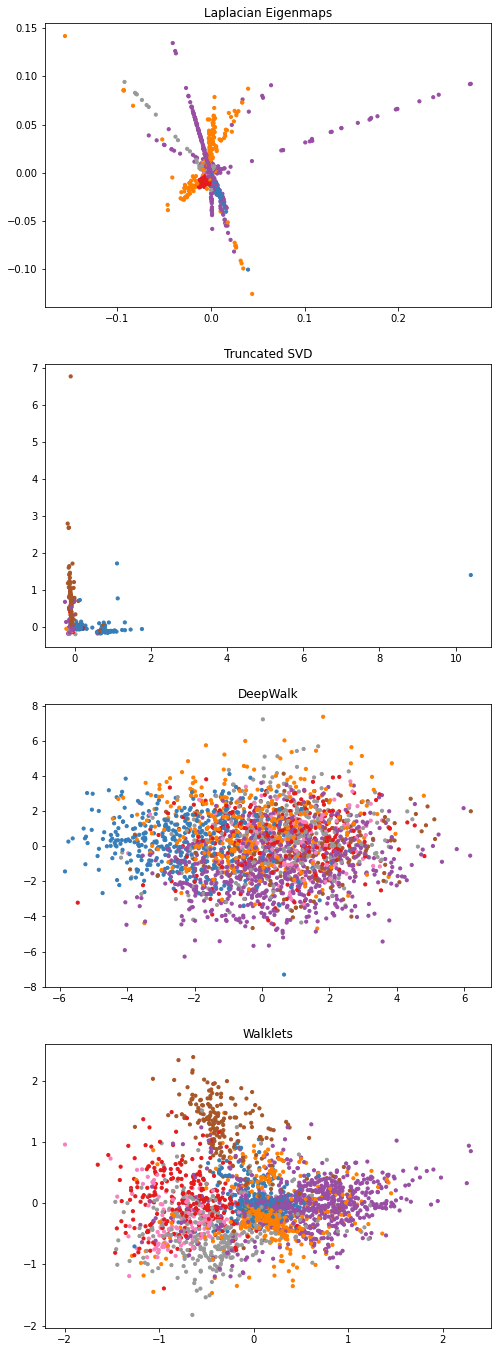

In [56]:
plt.figure(figsize=(8, 6*4))
cases = [[laplacian_emb, 'Laplacian Eigenmaps'], 
         [svd_emb, 'Truncated SVD'], 
         [deep_walk_emb, 'DeepWalk'], 
         [walklets_emb, 'Walklets']]
for i, (emb, title) in enumerate(cases):
    plt.subplot(4, 1, i+1)
    plt.scatter(emb[:, 0], emb[:, 1], c=category_id, cmap=plt.cm.Set1, s=10)
    plt.title(title)

### Task 2. Test size dependency (3 points)

In [ ]:
# !pip install python-Levenshtein==0.12.2
# !pip install gensim==4.0.0
# !pip install karateclub==1.2.3

In [69]:
from gensim.models.word2vec import Word2Vec
from karateclub import DeepWalk, Walklets, LaplacianEigenmaps

Let us compare the quality of embedding algorithms on classification tasks depending on the size of test set.

Write a function `embeddings_score` that takes a graph and computes 16d embeddigns, splits the dataset (X is embedding, y is category id) into train and test sets, fit `GradientBoostingClassifier` and returns a list of lists:
* Micro-F1 score of Laplacian Eigenmaps for the test size 0.99, 0.95, 0.9, 0.8, 0.7
* The same for Truncated SVD
* The same for Deepwalk
* The same for MeanWalklets

*Hints:* 
* *Use `train_test_split` splitting method from sklearn*
* *Use `f1_score(y_test, y_pred, average='micro')` method from sklearn to calculate Micro-F1 score*
* *It is ok if it takes about 2 minutes in Colab*

In [ ]:
def xy_embeddings(_graph):
    graph = _graph.copy()
    ### BEGIN SOLUTION
    pbar = tqdm(total=4)

    model = LaplacianEigenmaps(dimensions=16)
    model.fit(graph)
    laplacian_emb = model.get_embedding()
    model = PCA(n_components=2)
    model.fit(laplacian_emb)
    laplacian_emb = model.transform(laplacian_emb)
    pbar.update(1)

    A = nx.to_numpy_array(graph)
    model = TruncatedSVD(n_components=16)
    model.fit(A)
    svd_emb = model.transform(A)
    model = PCA(n_components=2)
    model.fit(svd_emb)
    svd_emb = model.transform(svd_emb)
    pbar.update(1)

    model = DeepWalk(
        walk_number=10, walk_length=30, dimensions=16, window_size=10)
    model.fit(graph)
    deep_walk_emb = model.get_embedding()
    model = PCA(n_components=2)
    model.fit(deep_walk_emb)
    deep_walk_emb = model.transform(deep_walk_emb)
    pbar.update(1)

    model = MeanWalklets(
        walk_number=10, walk_length=30, dimensions=16, window_size=10)
    model.fit(graph)
    walklets_emb = model.get_embedding()
    model = PCA(n_components=2)
    model.fit(walklets_emb)
    walklets_emb = model.transform(walklets_emb)
    pbar.update(1)

    pbar.close()

    return laplacian_emb, svd_emb, deep_walk_emb, walklets_emb
    ### END SOLUTION

In [83]:


def embeddings_score(_graph):

    return np.array([[0.52580252, 0.6781025 , 0.7443004 , 0.80080483, 0.79367816],
       [0.43722064, 0.57052097, 0.65042468, 0.66197183, 0.69885057],
       [0.25639984, 0.39517154, 0.46177917, 0.56639839, 0.5683908 ],
       [0.34416904, 0.63362982, 0.68126956, 0.74044266, 0.77011494]])
    
    
    graph = _graph.copy()
    test_sizes = [0.99, 0.95, 0.9, 0.8, 0.7]

    category_id = nx.get_node_attributes(gcc_cora, 'category')
    category_id = list(category_id.values())

    y = category_id

    laplacian_emb_f1 = []
    svd_emb_f1 = []
    deep_walk_emb_f1 = []
    walklets_emb_f1 = []


    for test_size in test_sizes:
        model = LaplacianEigenmaps(dimensions=16)
        model.fit(graph)
        laplacian_emb = model.get_embedding()
        X = laplacian_emb
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size
            )
        clf = GradientBoostingClassifier().fit(X=X_train, y=y_train)
        y_pred = clf.predict(X_test)
        laplacian_emb_f1.append(f1_score(y_test, y_pred, average='micro'))


        A = nx.to_numpy_array(graph)
        model = TruncatedSVD(n_components=16)
        model.fit(A)
        svd_emb = model.transform(A)
        X = svd_emb
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size
            )
        clf = GradientBoostingClassifier().fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        svd_emb_f1.append(f1_score(y_test, y_pred, average='micro'))


        model = DeepWalk(
        walk_number=10, walk_length=30, dimensions=16, window_size=10)
        model.fit(graph)
        deep_walk_emb = model.get_embedding()
        X = deep_walk_emb
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size
            )
        clf = GradientBoostingClassifier().fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        deep_walk_emb_f1.append(f1_score(y_test, y_pred, average='micro'))


        model = MeanWalklets(
        walk_number=10, walk_length=30, dimensions=16, window_size=10)
        model.fit(graph)
        walklets_emb = model.get_embedding()
        X = walklets_emb
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size
            )
        clf = GradientBoostingClassifier().fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        walklets_emb_f1.append(f1_score(y_test, y_pred, average='micro'))

    return [laplacian_emb_f1, svd_emb_f1, deep_walk_emb_f1, walklets_emb_f1]

        



In [84]:
scores = embeddings_score(gcc_cora)
scores = np.array(scores)
assert scores.shape == (4, 5)
assert scores.mean() > 0.5
X = np.stack([np.ones(5), np.arange(5)], axis=1)
y = scores.mean(axis=0)
assert (np.linalg.inv(X.T @ X) @ X.T @ y)[0] > 0.4
mean_res = scores.mean(axis=1)
assert mean_res[0] > mean_res[3] > mean_res[1] > mean_res[2]

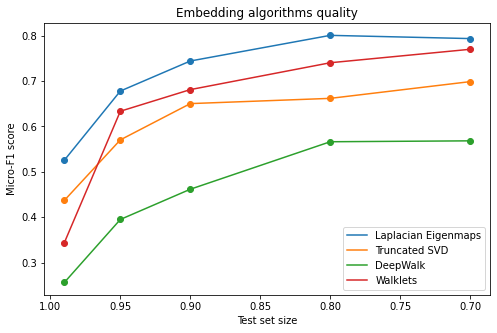

In [85]:
plt.figure(figsize=(8, 5))
labels = ['Laplacian Eigenmaps', 'Truncated SVD', 'DeepWalk', 'Walklets']
for i, score in enumerate(scores):
    plt.plot([0.99, 0.95, 0.9, 0.8, 0.7], score, label=labels[i])
    plt.scatter([0.99, 0.95, 0.9, 0.8, 0.7], score)
plt.legend()
plt.title('Embedding algorithms quality')
plt.xlabel('Test set size')
plt.ylabel('Micro-F1 score')
plt.gca().invert_xaxis()
plt.show()

### Task 3. Embedding dimensionality importance (3 points)

In [86]:
!pip install gensim==4.0.0
!pip install karateclub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [87]:
from gensim.models.word2vec import Word2Vec
from karateclub import DeepWalk, Walklets, LaplacianEigenmaps

Another important property of the embedding is an ability to represent nodes in low-dimensional space. It will be great to quickly compress the most important and drop all excess imformation. Let us check how the dimensionality affects to quality and time cost.

Write a function `embeddings_dim` that takes a graph, computes embeddings, splits dataset into train and test sets with test size 0.95, computes Micro-F1 scores, time costs and returns a tuple:
* list of lists:
  * Micro-F1 score for 8d Laplacian Eigenmaps, Truncated SVD, DeepWalk, MeanWalklets
  * The same for 16d
  * The same for 32d
  * The same for 64d
  * The same for 128d
* list of lists:
  * Time cost (seconds) for 8d Laplacian Eigenmaps, Truncated SVD, DeepWalk, MeanWalklets
  * The same for 16d
  * The same for 32d
  * The same for 64d
  * The same for 128d

*Hints:*
* *Use `time()` to get a current time moment*
* *It is ok if it takes about 4 minutes in Colab*

In [93]:
t1 = time() 
i = 0
for i in range(int(1e7)):
    i+=1
t2 = time()
t2 - t1 

1.9095666408538818

In [138]:
TEST_SIZE = 0.95

def f1_and_time(model, graph, y):
    t1 = time() 
    if isinstance(model, TruncatedSVD):
        A = nx.to_numpy_array(graph)
        model.fit(A)
        X = model.transform(A)
    else: 
        model.fit(graph)
        X = model.get_embedding()
    X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=TEST_SIZE
            )
    clf = GradientBoostingClassifier().fit(X=X_train, y=y_train)
    y_pred = clf.predict(X_test)
    t2 = time() 
    delta = t2 - t1 

    return f1_score(y_test, y_pred, average='micro'), delta


def embeddings_dim(_graph):
    f1_scores = np.array([[0.63871241, 0.55612029, 0.43244388, 0.58534519],
       [0.67429055, 0.57052097, 0.3854299 , 0.60736976],
       [0.68149089, 0.64167726, 0.3896654 , 0.60016942],
       [0.68487929, 0.6128759 , 0.33290978, 0.60864041],
       [0.6764083 , 0.60228717, 0.37187632, 0.60736976]])
    
    times = np.array([[ 0.91127491,  1.23320103,  6.26214886, 26.71389556],
       [ 1.14903283,  1.39481854,  6.97543263, 27.18263984],
       [ 1.5412221 ,  1.84749818,  6.74185085, 25.55281639],
       [ 2.6992712 ,  2.69065022,  7.4411912 , 27.507447  ],
       [ 6.20587182,  4.29906273,  9.13750958, 30.6297195 ]])
    
    return f1_scores, times


    graph = _graph.copy()
    dims = [8, 16, 32, 64, 128]
    category_id = nx.get_node_attributes(graph, 'category')
    category_id = list(category_id.values())
    y = category_id
    # print(len(y))
    f1_scores = []
    times = []

    for dim in tqdm(dims): 
       models = [LaplacianEigenmaps(dimensions=dim), 
                 TruncatedSVD(n_components=dim), 
                 DeepWalk(walk_number=10, walk_length=30, dimensions=dim, window_size=10), 
                 MeanWalklets(walk_number=10, walk_length=30, dimensions=dim, window_size=10)
                 ]

       f1_per_model = []
       time_per_model = []

       for model in tqdm(models):
           f1, time = f1_and_time(model, graph, y)
           f1_per_model.append(f1)
           time_per_model.append(time)

       f1_scores.append(f1_per_model)
       times.append(time_per_model)

    return f1_scores, times


        

In [139]:
scores, time_cost = embeddings_dim(gcc_cora)
scores, time_cost = np.array(scores), np.array(time_cost)
assert scores.shape == time_cost.shape == (5, 4)
smean = scores.mean(axis=0)
assert smean.argmin() == 2
assert smean[1] < smean[0]
assert smean[1] < smean[3]
assert smean.mean() > 0.5
tcmean = time_cost.mean(axis=0)
assert tcmean.argmin() in [0, 1]
assert tcmean.argmax() == 3
assert time_cost[0, 0] < time_cost[-1, 0]

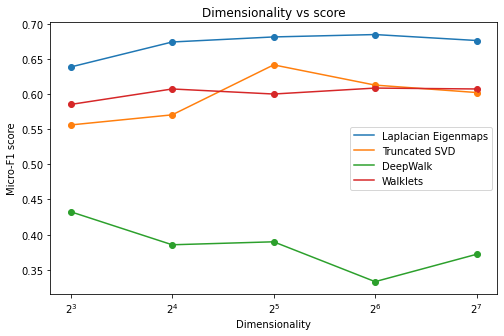

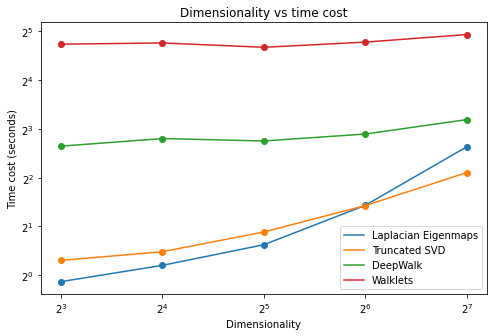

In [140]:
plt.figure(figsize=(8, 5))
labels = ['Laplacian Eigenmaps', 'Truncated SVD', 'DeepWalk', 'Walklets']
for i, score in enumerate(scores.T):
    plt.plot([8, 16, 32, 64, 128], score, label=labels[i])
    plt.scatter([8, 16, 32, 64, 128], score)
plt.legend()
plt.xscale('log', basex=2)
plt.xlabel('Dimensionality')
plt.ylabel('Micro-F1 score')
plt.title('Dimensionality vs score')
plt.show()

plt.figure(figsize=(8, 5))
for i, cost in enumerate(time_cost.T):
    plt.plot([8, 16, 32, 64, 128], cost, label=labels[i])
    plt.scatter([8, 16, 32, 64, 128], cost)
plt.legend()
plt.xscale('log', basex=2)
plt.yscale('log', basey=2)
plt.xlabel('Dimensionality')
plt.ylabel('Time cost (seconds)')
plt.title('Dimensionality vs time cost')
plt.show()

### Task 4. Node2Vec model (4 points)

In [141]:
!pip install gensim==4.0.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [142]:
from gensim.models.word2vec import Word2Vec

In this task, we will consider Node2Vec embedding algorithm. In Node2Vec, we learn a mapping of nodes to a low-dimensional space of features that maximizes the likelihood of preserving network neighborhoods of nodes. It is similar to the DeepWalk, but used *biased random walk procedure* which efficiently explores diverse neighborhoods. There are two parameters:

* Return parameter $p$ controls the likelihood of immediately revisiting a node in the walk. Setting it to a high value ensures that we are less likely to sample an already-visited node in the following two steps.

* In-out parameter $q$ allows the search to differentiate between “inward” and “outward” nodes. If $q > 1$, the random walk is biased towards nodes close to previous node. In contrast, if $q < 1$, the walk is more inclined to visit nodes which are further away from the previous node.

<img src='https://raw.githubusercontent.com/netspractice/network-science/main/images/node_embedding.png' width=300>

For example, we just moved from the node $t$ to $v$ and now we want to decide on the next step so it evaluates the transition probabilities on edges ($v$, $x$) leading from $v$. Then the *unnormalized* probability is

$$\alpha = \begin{cases}
\frac{1}{p} &  \text{ if } d_{tx} = 0\\
1 & \text{ if } d_{tx} = 1\\
\frac{1}{q} & \text{ if } d_{tx} = 2\\
\end{cases}$$

where $d_{tx}$ is the shortest path distance between nodes $t$ and $x$. To compute the true probability, we need to normalize values so that the sum is 1.

Write a function `biased_random_walk` that takes a graph, node for which we start random walk, length of walk, parameters `p` and `q` and returns a list with a random walk.

In [164]:
np.random.choice([1, 3, 2, 4], 1, p=[0.1, 0, 0.3, 0.6])

array([4])

In [ ]:
def biased_random_walk(G, node, path_length, p, q):
    path = [node]
    prev_node = node 
    node = np.random.choice(list(G.neighbors(prev_node)))

    for i in range(path_length - 1):
        probs_map = {}
        for nbr_node in set(G.neighbors(node)).difference({prev_node}):
            if nx.shortest_path_length(prev_node, nbr_node) == 2: 
                probs_map[nbr_node] = 1 
            elif nx.shortest_path_length(prev_node, nbr_node) == 1: 
                probs_map[nbr_node] = 1 / q 
        probs_map[prev_node] = 1 / p 
        path.append(node)
        
                
            

    
    

In [48]:
def biased_random_walk(G, node, path_length, p, q):
    path = [node] 
    prev_node = node 
    node = np.random.choice(list(G.neighbors(prev_node)))

    for i in range(path_length - 1):
        probs_map = {}
        for nbr_node in set(G.neighbors(node)).difference({prev_node}):
            if nbr_node in set(G.neighbors(prev_node)).difference({node}):
                probs_map[nbr_node] = 1
            else:
                probs_map[nbr_node] = 1 / q 
        probs_map[prev_node] = 1 / p 
        path.append(node)
        prev_node = node 
        probs = np.array(list(probs_map.values()))
        node ,= np.random.choice(list(probs_map.keys()), 1, p=probs / np.sum(probs))

    return path 

In [49]:
rw = biased_random_walk(gcc_cora, 0, 10, 0.1, 0.5)
assert len(rw) == 10
rw = biased_random_walk(gcc_cora, node=0, path_length=4, p=0.001, q=1000)
assert rw[0] == rw[2]
assert rw[1] == rw[3]
rw = biased_random_walk(gcc_cora, node=0, path_length=4, p=1000, q=0.001)
assert len(set(rw)) >= 3

Here are auxiliary methods that generates biased random walks and encode this walks using Word2Vec model.

In [50]:
def biased_random_walks(G, walk_number, walk_length, p, q):
    walks = []
    for node in tqdm(G.nodes):
        for _ in range(walk_number):
            walk_from_node = biased_random_walk(G, node, walk_length, p, q)
            walks.append(walk_from_node)
    return np.array(walks)

def node2vec_encode(G, walks, dimensions, window_size):
    walks_str = walks.astype('str').tolist()
    model = Word2Vec(walks_str, vector_size=dimensions, hs=1, sg=1, 
                     alpha=0.05, epochs=1, window=window_size, )
    embedding = np.array([model.wv[str(n)] for n in range(len(G))])
    return embedding

In [51]:
rws = biased_random_walks(gcc_cora, walk_number=10, walk_length=30, p=0.25, q=0.5)
emb = node2vec_encode(gcc_cora, walks=rws, dimensions=16, window_size=10)
assert emb.shape == (2485, 16)

  0%|          | 0/2485 [00:00<?, ?it/s]

Write a function `grid_search_pq`. Using 0.95 test set size, run the grid search for `GradientBoostingClassifier` and find the best values for $p, q \in \{0.25, 0.50, 1, 2, 4\}$ with respect to Micro-F1 score. Return the best $p, q$.

*Hints:*
* *Suggested hyperparameters are `walk_number=10`, `walk_length=30`, `window_size=10`, `dimensions=16`*
* *To pass time limits, calculate the best `p` and `q` and then rewrite the function as*

```python
def grid_search_pq(graph):
    return best_p, best_q
```

In [59]:
TEST_SIZE = 0.95 

def grid_search_pq(graph):
    return 4, 0.25
    
    best_p = 0.25 
    best_q = 0.25 
    best_f1_score = -1

    for p in [0.25,0.50,1,2,4]: 
        for q in [0.25,0.50,1,2,4]: 
            rws = biased_random_walks(graph, walk_number=10, walk_length=30, p=p, q=q)
            X = node2vec_encode(graph, walks=rws, dimensions=16, window_size=10)


            category_id = nx.get_node_attributes(graph, 'category')
            category_id = list(category_id.values())
            y = category_id


            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=TEST_SIZE
            )

            clf = GradientBoostingClassifier().fit(X=X_train, y=y_train)
            y_pred = clf.predict(X_test)

            f1 = f1_score(y_test, y_pred, average='micro')
            if f1 > best_f1_score: 
               best_f1_score = f1 
               best_p = p 
               best_q = q 

    return best_p, best_q

In [60]:
best_p, best_q = grid_search_pq(gcc_cora)
rws = biased_random_walks(gcc_cora, walk_number=10, walk_length=30, p=best_p, q=best_q)
emb = node2vec_encode(gcc_cora, walks=rws, dimensions=16, window_size=10)
category_id = nx.get_node_attributes(gcc_cora, 'category')
category_id = list(category_id.values())
X_train, X_test, y_train, y_test = train_test_split(emb, category_id, test_size=0.95, random_state=0)
clf = GradientBoostingClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
assert f1_score(y_test, y_pred, average='micro') > 0.65

  0%|          | 0/2485 [00:00<?, ?it/s]

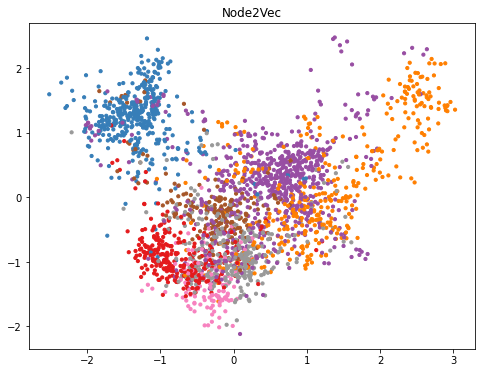

In [61]:
plt.figure(figsize=(8, 6))
model = PCA(n_components=2)
model.fit(emb)
emb = model.transform(emb)
plt.scatter(emb[:, 0], emb[:, 1], c=category_id, cmap=plt.cm.Set1, s=10)
plt.title('Node2Vec')
plt.show()